<a href="https://colab.research.google.com/github/joaofranca13/ml-experiments/blob/main/car_price_randforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [258]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline


%matplotlib inline

In [212]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [213]:
!wget $data 

--2022-08-24 00:34:27--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv.4’

data.csv.4          100%[===================>]   1.41M  --.-KB/s    in 0.07s   

2022-08-24 00:34:28 (20.7 MB/s) - ‘data.csv.4’ saved [1475504/1475504]



In [214]:
df = pd.read_csv("/content/data.csv")

In [215]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## Data Preparation

In [216]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

In [217]:
text_cols = list(df.dtypes[df.dtypes == "object"].index)
text_cols

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [218]:
for col in text_cols:
  df[col] = df[col].str.lower().str.replace(' ', '_')

In [219]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


## EDA

In [220]:
df.isna().sum().sort_values(ascending=False)

market_category      3742
engine_hp              69
engine_cylinders       30
number_of_doors         6
engine_fuel_type        3
make                    0
model                   0
year                    0
transmission_type       0
driven_wheels           0
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [221]:
for col in df.columns:
  print(col)
  print(df[col].value_counts().head(20))
  print("================")

make
chevrolet        1123
ford              881
volkswagen        809
toyota            746
dodge             626
nissan            558
gmc               515
honda             449
mazda             423
cadillac          397
mercedes-benz     353
suzuki            351
bmw               334
infiniti          330
audi              328
hyundai           303
volvo             281
subaru            256
acura             252
kia               231
Name: make, dtype: int64
model
silverado_1500        156
tundra                140
f-150                 126
sierra_1500            90
beetle_convertible     89
tacoma                 80
gti                    76
frontier               76
beetle                 75
accord                 75
civic                  68
dakota                 65
ram_pickup_1500        62
jetta                  61
corvette               60
911                    58
c/k_1500_series        56
xc60                   54
colorado               54
3                      53
Name

In [222]:
#sns.pairplot(df)

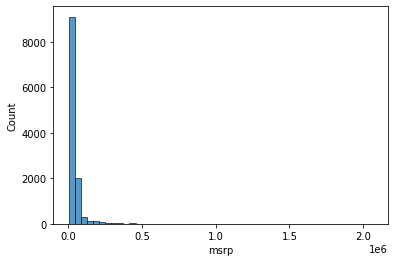

In [223]:
sns.histplot(df['msrp'], bins=50)

In [224]:
df['msrp'].describe().T

count    1.191400e+04
mean     4.059474e+04
std      6.010910e+04
min      2.000000e+03
25%      2.100000e+04
50%      2.999500e+04
75%      4.223125e+04
max      2.065902e+06
Name: msrp, dtype: float64

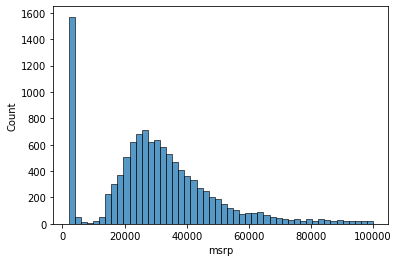

In [225]:
sns.histplot(df['msrp'][df['msrp'] < 100000], bins=50)

In [226]:
df['msrp'][df['msrp'] < 100000].describe().T

count    11276.000000
mean     30476.444395
std      18633.369504
min       2000.000000
25%      20395.000000
50%      29095.000000
75%      39516.250000
max      99950.000000
Name: msrp, dtype: float64

In [227]:
df['msrp_log'] = np.log1p(df['msrp'])

In [228]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,msrp_log
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135,10.739349
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650,10.612779
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350,10.500977
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450,10.290483
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500,10.448744


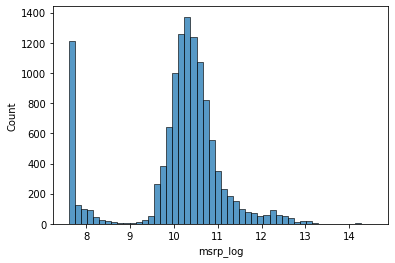

In [229]:
sns.histplot(df['msrp_log'], bins=50)

## Feature Engineering

In [230]:
curr_year = df['year'].max()

df['age'] =  curr_year - df['year']
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,msrp_log,age
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135,10.739349,6
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650,10.612779,6
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350,10.500977,6
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450,10.290483,6
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500,10.448744,6


In [232]:
df.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp', 'msrp_log', 'age'],
      dtype='object')

## Model Validation Framework

In [248]:
features = ['make', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp_log', 'age']

X = df[features].copy()
X_train, X_validate, X_test = np.split(X.sample(frac=1, random_state=0), [int(.6*len(df)), int(.8*len(df))])

In [249]:
X_train, X_validate, X_test = X_train.reset_index(drop=True), X_validate.reset_index(drop=True), X_test.reset_index(drop=True)

In [250]:
print("Full Dataframe: " + str(round(X.shape[0]/X.shape[0], 4)))
print("Train Dataframe: " + str(round(X_train.shape[0]/X.shape[0], 4)))
print("Validation Dataframe: " + str(round(X_validate.shape[0]/X.shape[0], 4)))
print("Test Dataframe: " + str(round(X_test.shape[0]/X.shape[0], 4)))
print("Check (Must be 0): " + str(X.shape[0] - X_train.shape[0] - X_validate.shape[0] - X_test.shape[0]))

Full Dataframe: 1.0
Train Dataframe: 0.6
Validation Dataframe: 0.2
Test Dataframe: 0.2
Check (Must be 0): 0


In [251]:
y_train, y_validate, y_test = X_train["msrp_log"], X_validate["msrp_log"], X_test["msrp_log"]

In [252]:
X_train = X_train.drop(['msrp_log'], axis=1)
X_validate = X_validate.drop(['msrp_log'], axis=1)
X_test = X_test.drop(['msrp_log'], axis=1)

In [253]:
print([len(X_train), len(y_train)])
print([len(X_validate), len(y_validate)])
print([len(X_test), len(y_test)])

[7148, 7148]
[2383, 2383]
[2383, 2383]


In [254]:
X_train.head()

,make,engine_hp,engine_cylinders,transmission_type,driven_wheels,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,age
0,ford,275.0,6.0,automatic,rear_wheel_drive,midsize,passenger_van,19,14,5657,0
1,oldsmobile,205.0,6.0,automatic,front_wheel_drive,large,sedan,27,17,26,18
2,ford,385.0,8.0,automatic,four_wheel_drive,large,crew_cab_pickup,21,15,5657,0
3,dodge,485.0,8.0,automatic,rear_wheel_drive,large,sedan,25,15,1851,0
4,mazda,274.0,4.0,manual,all_wheel_drive,midsize,sedan,23,17,586,11


In [255]:
X_train.columns

Index(['make', 'engine_hp', 'engine_cylinders', 'transmission_type',
       'driven_wheels', 'vehicle_size', 'vehicle_style', 'highway_mpg',
       'city_mpg', 'popularity', 'age'],
      dtype='object')

In [256]:
def rmse(actual, predicted):
  error = predicted - actual
  mse = (error ** 2).mean()
  rmse = np.sqrt(mse)
  return rmse

## Modelling

In [268]:
ordinal_features = 'vehicle_size'
label_features = ['make', 'transmission_type', 'driven_wheels', 'vehicle_style']

In [269]:
na_imputer = MeanMedianImputer(imputation_method='median')

In [270]:
ordinal_encoder = OrdinalEncoder(encoding_method='ordered', variables=ordinal_features)

In [271]:
onehot_encoder = OneHotEncoder(variables=label_features)

In [272]:
reg = RandomForestRegressor(random_state=0)

In [274]:
model_pipeline = make_pipeline(
    na_imputer,
    ordinal_encoder,
    onehot_encoder,
    reg
)

In [276]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('meanmedianimputer', MeanMedianImputer()),
                ('ordinalencoder', OrdinalEncoder(variables='vehicle_size')),
                ('onehotencoder',
                 OneHotEncoder(variables=['make', 'transmission_type',
                                          'driven_wheels', 'vehicle_style'])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=0))])

In [278]:
y_pred = model_pipeline.predict(X_train)


# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# The root mean squared error
print("Root mean squared error: %.2f" % rmse(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred))

Mean squared error: 0.00
Root mean squared error: 0.06
Coefficient of determination: 1.00


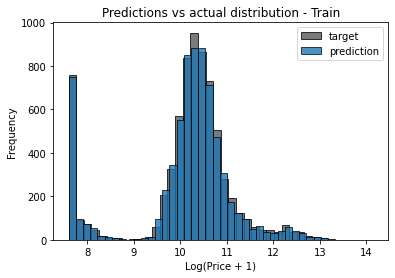

In [280]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution - Train')

plt.show()

## Validation

In [281]:
X_validate.shape

(2383, 11)

In [282]:
X_train.shape

(7148, 11)

In [283]:
y_pred = model_pipeline.predict(X_validate)


# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_validate, y_pred))
# The root mean squared error
print("Root mean squared error: %.2f" % rmse(y_validate, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_validate, y_pred))

Mean squared error: 0.01
Root mean squared error: 0.11
Coefficient of determination: 0.99


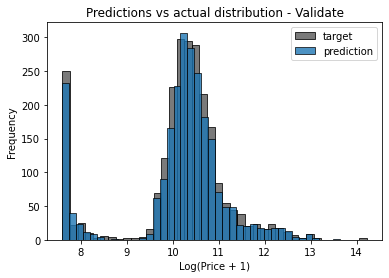

In [284]:
plt.figure(figsize=(6, 4))

sns.histplot(y_validate, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution - Validate')

plt.show()

## Full Training

In [285]:
X_full_train = pd.concat([X_train, X_validate])
X_full_train

,make,engine_hp,engine_cylinders,transmission_type,driven_wheels,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,age
0,ford,275.0,6.0,automatic,rear_wheel_drive,midsize,passenger_van,19,14,5657,0
1,oldsmobile,205.0,6.0,automatic,front_wheel_drive,large,sedan,27,17,26,18
2,ford,385.0,8.0,automatic,four_wheel_drive,large,crew_cab_pickup,21,15,5657,0
3,dodge,485.0,8.0,automatic,rear_wheel_drive,large,sedan,25,15,1851,0
4,mazda,274.0,4.0,manual,all_wheel_drive,midsize,sedan,23,17,586,11
...,...,...,...,...,...,...,...,...,...,...,...
2378,suzuki,166.0,4.0,automatic,rear_wheel_drive,compact,4dr_suv,25,19,481,5
2379,gmc,285.0,8.0,automatic,rear_wheel_drive,large,cargo_van,17,11,549,2
2380,saab,200.0,4.0,manual,front_wheel_drive,midsize,4dr_hatchback,26,18,376,20
2381,subaru,148.0,4.0,automatic,all_wheel_drive,compact,4dr_hatchback,37,28,640,1


In [286]:
y_full_training = np.concatenate([y_train, y_validate])
len(y_full_training)

9531

In [287]:
model_pipeline.fit(X_full_train, y_full_training)

Pipeline(steps=[('meanmedianimputer', MeanMedianImputer()),
                ('ordinalencoder', OrdinalEncoder(variables='vehicle_size')),
                ('onehotencoder',
                 OneHotEncoder(variables=['make', 'transmission_type',
                                          'driven_wheels', 'vehicle_style'])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=0))])

In [288]:
y_pred = model_pipeline.predict(X_test)


# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The root mean squared error
print("Root mean squared error: %.2f" % rmse(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 0.02
Root mean squared error: 0.12
Coefficient of determination: 0.99


Text(0.5, 1.0, 'Predictions vs actual distribution - Test')

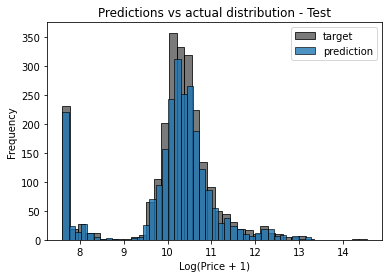

In [290]:
plt.figure(figsize=(6, 4))

sns.histplot(y_test, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution - Test')


In [292]:
model = pd.Series({"model": model_pipeline})
model.to_pickle('/content/models/rand_forest_car_price_regressor.pkl')